<a href="https://colab.research.google.com/github/OgunSerifOnargan/VBM683-MachineLearning/blob/main/SoccerMLFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from google.colab import files 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install opendatasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import opendatasets as od
import pandas
od.download("https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset")
#main datasets
logs = pd.read_csv("/content/soccer-match-event-dataset/features.csv")
logs.fillna(0,inplace=True)
logs["time_pass-0"] = logs["time_played-0"] - logs["time_played-1"]
feature_logs = logs[(logs["period_id-0"]==1) | ((logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350))]
# feature_logs = logs[(logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350)]
target_logs = logs[(logs["period_id-0"]==2) & (logs["time_seconds-0"]>1350)]
goal_logs = logs[(logs["period_id-0"]==1) | ((logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350))]
sampleMatch = logs[logs["game_id-0"]==2500089]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./soccer-match-event-dataset" (use force=True to force download)


In [ ]:
#@title
# According to event type, it creates df for each meter in x-axis

def event_df_creator_final(data, feature, val_min, val_max):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  name = (str(val_min) + " <= " + feature + " <= " + str(val_max))
  event_count = data[(data["type_name-0"]==feature) & (data["start_x-0"]<=val_max) & (data["start_x-0"]>=val_min)].groupby("game_id-0")["Unnamed: 0"].count()
  df_event_count = pd.DataFrame(event_count.values, index=event_count.index, columns=[name])
  df_final = pd.concat([df_final, df_event_count], axis=1)
  # target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  # df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])
  # result = pd.concat([df_final, df_target_corner], axis=1)
  df_final.fillna(0, inplace=True)
  return df_final


def event_df_creator(data, event, event_type):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  for i in range(1,105):
    name = (event + " < " + str(i)) 
    if event_type == "off":
      list_event = data[(data["type_name-0"]==event) & (data["start_x-0"]<=i)].groupby("game_id-0")["Unnamed: 0"].count()
    if event_type == "def":
      list_event = data[(data["type_name-0"]==event) & (data["start_x-1"]<=i)].groupby("game_id-0")["Unnamed: 0"].count()

    df_event = pd.DataFrame(list_event.values, index=list_event.index, columns=[name])
    df_final = pd.concat([df_final, df_event], axis=1)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
  df_eventandTargetCorners = pd.concat([df_final, df_target_corners], axis=1)
  df_eventandTargetCorners.fillna(0, inplace=True)
  return df_eventandTargetCorners

#Plotting correlation for an event and each meter of x-axis

def event_corr_plot(event, event_type):
  df_event = event_df_creator(feature_logs, event, event_type)
  event_corr = df_event.corr()
  plt.plot(range(1,105), event_corr["total_corner"].iloc[:-1])
  plt.xlabel("X-Axis")
  ylabel = event + " Corr"
  plt.ylabel(ylabel)


In [ ]:
#@title
def event_df_btw_val(data, feature, val_min, val_max):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  for i in range(val_min, val_max):
    for j in range(val_min,i):
      name = (str(j) + " <= " + feature + " <= " + str(i))
      event_count = data[(data["type_name-0"]==feature) & (data["start_x-0"]<=i) & (data["start_x-0"]>=j)].groupby("game_id-0")["Unnamed: 0"].count()
      df_event_count = pd.DataFrame(event_count.values, index=event_count.index, columns=[name])
      df_final = pd.concat([df_final, df_event_count], axis=1)
  target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])
  result = pd.concat([df_final, df_target_corner], axis=1)
  result.fillna(0, inplace=True)
  return result

In [ ]:
#@title
def event_analysis(event):
  display(logs[logs["type_name-0"]==event]["Unnamed: 0"].count())

  best = [0, 0]
  ratio_list = []
  for i in range(1,105):
    int_corner = logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["start_x-1"]<i) & (logs["type_name-1"]==event)]["Unnamed: 0"].count() 
    int_total = logs[(logs["type_name-1"]==event) & (logs["start_x-1"]<i)]["Unnamed: 0"].count() 
    ratio = int_corner/int_total
    ratio_list.append(ratio)
    if ratio>best[0]:
      best[0] = ratio
      best[1] = i
    print("Ratio is: " + str(ratio) + " in " + str(i))
  print(best)

  plt.plot(range(1,105), ratio_list)
  plt.xlabel("X-Axis")
  plt.ylabel(event + " Cause Corner /" + "Total " + event)
  plt.show()

  event_corr_plot(event, "off")
  plt.show()

  display(logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["type_name-1"]==event)].groupby("type_name-2")["Unnamed: 0"].count().sort_values(ascending=False))

  int_interval_detect = event_df_btw_val(feature_logs, event, 0, 106).corr()
  print(int_interval_detect[int_interval_detect.columns[-1]][:-1])
  print(min(int_interval_detect[int_interval_detect.columns[-1]][:-1]))
  print(max(int_interval_detect[int_interval_detect.columns[-1]][:-1]))



def event_analysis_off(event):
  display(logs[logs["type_name-0"]==event]["Unnamed: 0"].count())

  best = [0, 0]
  ratio_list = []
  for i in range(1,105):
    int_corner = logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["start_x-1"]<i) & ((logs["type_name-1"]==event) | (logs["type_name-2"]==event))]["Unnamed: 0"].count() 
    int_total = logs[(logs["type_name-1"]==event) & (logs["start_x-1"]<i)]["Unnamed: 0"].count() 
    ratio = int_corner/int_total
    ratio_list.append(ratio)
    if ratio>best[0]:
      best[0] = ratio
      best[1] = i
    print("Ratio is: " + str(ratio) + " in " + str(i))
  print(best)

  plt.plot(range(1,105), ratio_list)
  plt.xlabel("X-Axis")
  plt.ylabel(event + " Cause Corner /" + "Total " + event)
  plt.show()

  event_corr_plot(event, "off")
  plt.show()

  display(logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & ((logs["type_name-1"]==event) | (logs["type_name-2"]==event))].groupby("type_name-2")["Unnamed: 0"].count().sort_values(ascending=False))

  int_interval_detect = event_df_btw_val(feature_logs, event, 0, 106).corr()
  print(int_interval_detect[int_interval_detect.columns[-1]][:-1])
  print(min(int_interval_detect[int_interval_detect.columns[-1]][:-1]))
  print(max(int_interval_detect[int_interval_detect.columns[-1]][:-1]))

In [ ]:
#@title
def pos_df_creator(x1, x2, pos_type):
  matchID = feature_logs["game_id-0"].unique()
  df_pos = pd.DataFrame(index=matchID)
  name = "POS " + str(x1) + "<" + " x " + str(x2)
  if pos_type=="time":
    df_pos [name] = feature_logs[(feature_logs["start_x-0"]>x1) & (feature_logs["start_x-0"]<=x2)].groupby("game_id-0")["time_pass-0"].sum()
  if pos_type=="count":
    df_pos [name] = feature_logs[(feature_logs["start_x-0"]>x1) & (feature_logs["start_x-0"]<=x2)].groupby("game_id-0")["time_pass-0"].count()
  df_pos.fillna(0, inplace=True)
  return df_pos

def pos_table(x1,x2, pos_type):
  matchID = feature_logs["game_id-0"].unique()
  pos_table = pd.DataFrame(index=matchID)
  for i in range(x1,x2):
    for j in range(0,i):
      if pos_type=="time":
        df_pos_game = pos_df_creator(j,i, "time")
      if pos_type=="count":
        df_pos_game = pos_df_creator(j,i, "count")
      pos_table = pd.concat([pos_table, df_pos_game], axis=1)
  return pos_table

def pos_corr_table(pos_type):
  POS = pos_table(1,106, pos_type)
  POS.fillna(0, inplace=True)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
  df_poss = pd.concat([POS, df_target_corners], axis=1)
  df_poss.fillna(0,inplace=True)
  df_poss_corr=df_poss.corr()
  print(df_poss_corr[df_poss_corr.columns[-1]][:-1])

In [ ]:
#@title
def line_df_creator(x):
  matchID = feature_logs["game_id-0"].unique()
  df_crossingLine = pd.DataFrame(index=matchID)
  name = "Crossing Line " + str(x)
  df_line = feature_logs[((feature_logs["start_x-0"]<x) & (feature_logs["end_x-0"]>x)) | ((feature_logs["start_x-0"]>x) & (feature_logs["end_x-0"]<x))]
  df_line_matches = df_line.groupby("game_id-0")["Unnamed: 0"].count()
  df_crossingLine[name] = df_line_matches
  return df_crossingLine

def line_table(x):
  matchID = feature_logs["game_id-0"].unique()
  line_table = pd.DataFrame(index=matchID)
  for i in range(1,x):
    line = line_df_creator(i)
    line_table = pd.concat([line_table, line], axis=1)
  return line_table

def line_corr_table(x):
  line = line_table(x)
  line.fillna(0, inplace=True)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])

  df_line = pd.concat([line, df_target_corners], axis=1)
  df_line.fillna(0, inplace=True)
  df_line_corr=df_line.corr()
  print(df_line_corr[df_line_corr.columns[-1]][:-1])
  return df_line_corr[df_line_corr.columns[-1]][:-1]

In [ ]:
#@title
matchID = feature_logs["game_id-0"].unique()
goals_df = pd.DataFrame(index=matchID, columns=["goals"])
goals_diff_df = pd.DataFrame(index=matchID, columns=["goals_diff"])
for i, val in enumerate(matchID):
  game = feature_logs[feature_logs["game_id-0"] == val]

  goals_home = len(game[((game["type_name-0"]=="shot_freekick") | (game["type_name-0"]=="shot") | (game["type_name-0"]=="shot_penalty")) & 
                        (game["result_name-0"]=="success") & (game["team_id-0"] == game["team_id-0"].unique()[0])])

  goals_away = len(game[((game["type_name-0"]=="shot_freekick") | (game["type_name-0"]=="shot") | 
                        (game["type_name-0"]=="shot_penalty")) & (game["result_name-0"]=="success") & 
                        (game["team_id-0"] == game["team_id-0"].unique()[1])])
  goals = goals_home + goals_away
  goals_diff = abs(goals_home - goals_away)
  goals_df["goals"][val] = goals
  goals_diff_df["goals_diff"][val] = goals_diff

target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])

goal_df = pd.concat([goals_df, goals_diff_df, df_target_corners], axis=1)
goal_df.fillna(0, inplace=True)
goal_df_final = goal_df.drop("total_corner", axis=1)
df_goal_corr=goal_df.corr()
print(df_goal_corr[df_goal_corr.columns[-1]][:-1])

goals        -0.03
goals_diff   -0.07
Name: total_corner, dtype: float64


In [ ]:
#@title
df_final = pd.DataFrame(index=logs["game_id-0"].unique())

#EVENTS
interception_1 = event_df_creator_final(feature_logs,"interception", 40, 46)
interception_2 = event_df_creator_final(feature_logs,"interception", 83, 100)

clearance_1 = event_df_creator_final(feature_logs, "clearance", 22, 31)
clearance_2 = event_df_creator_final(feature_logs, "clearance", 92, 98)

shot_1 = event_df_creator_final(feature_logs, "shot", 19, 22)

keeper_save_1 = event_df_creator_final(feature_logs, "keeper_save", 0, 4)
keeper_save_2 = event_df_creator_final(feature_logs, "keeper_save", 5, 9)
keeper_save_3 = event_df_creator_final(feature_logs, "keeper_save", 17, 19)

pass_1 = event_df_creator_final(feature_logs, "pass", 53, 90)
pass_2 = event_df_creator_final(feature_logs, "pass", 0, 12)

dribbling_1 = event_df_creator_final(feature_logs, "dribble", 8, 28)

#POSESSIONS
pos_time_1 = pos_df_creator(34, 94, "time")
pos_time_2 = pos_df_creator(3, 34, "time")
pos_time_3 = pos_df_creator(94, 100, "time")
pos_time_4 = pos_time_2["POS 3< x 34"] + pos_time_3["POS 94< x 100"]

pos_count_1 = pos_df_creator(4, 30, "count")
pos_count_2 = pos_df_creator(49, 82, "count")
pos_count_3 = pos_df_creator(95, 100, "count")
pos_count_4 = pos_count_1["POS 4< x 30"] + pos_count_3["POS 95< x 100"]

#CROSSING LINE
crossing_line_1 = line_df_creator(18)

#GOALS
goals = goal_df_final

realized_corner = feature_logs[(feature_logs["type_name-0"]=="corner_crossed") | (feature_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_realized_corner = pd.DataFrame(realized_corner.values, index=realized_corner.index, columns=["realized_corner"])

target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])

y=df_target_corner["total_corner"]
med_y = np.median(y)
y[y<med_y] = 0
y[y>=med_y] = 1

df_final = pd.concat([interception_1, interception_2, clearance_1, clearance_2, shot_1, keeper_save_1, keeper_save_2, keeper_save_3, pass_1, pass_2, 
                      dribbling_1, pos_time_1, pos_time_2, pos_time_3, pos_time_4, pos_count_1, pos_count_2, pos_count_3, 
                      pos_count_4, crossing_line_1, goals, df_realized_corner, df_target_corner], axis=1)
df_final.fillna(0, inplace=True)

In [ ]:
df_final.columns

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner',              'total_corner'],
      dtype='object')

In [ ]:
#@title
y=df_final["total_corner"]
med_y = np.median(y)
y[y<med_y] = 0
y[y>=med_y] = 1

Text(0, 0.5, 'total_corner')

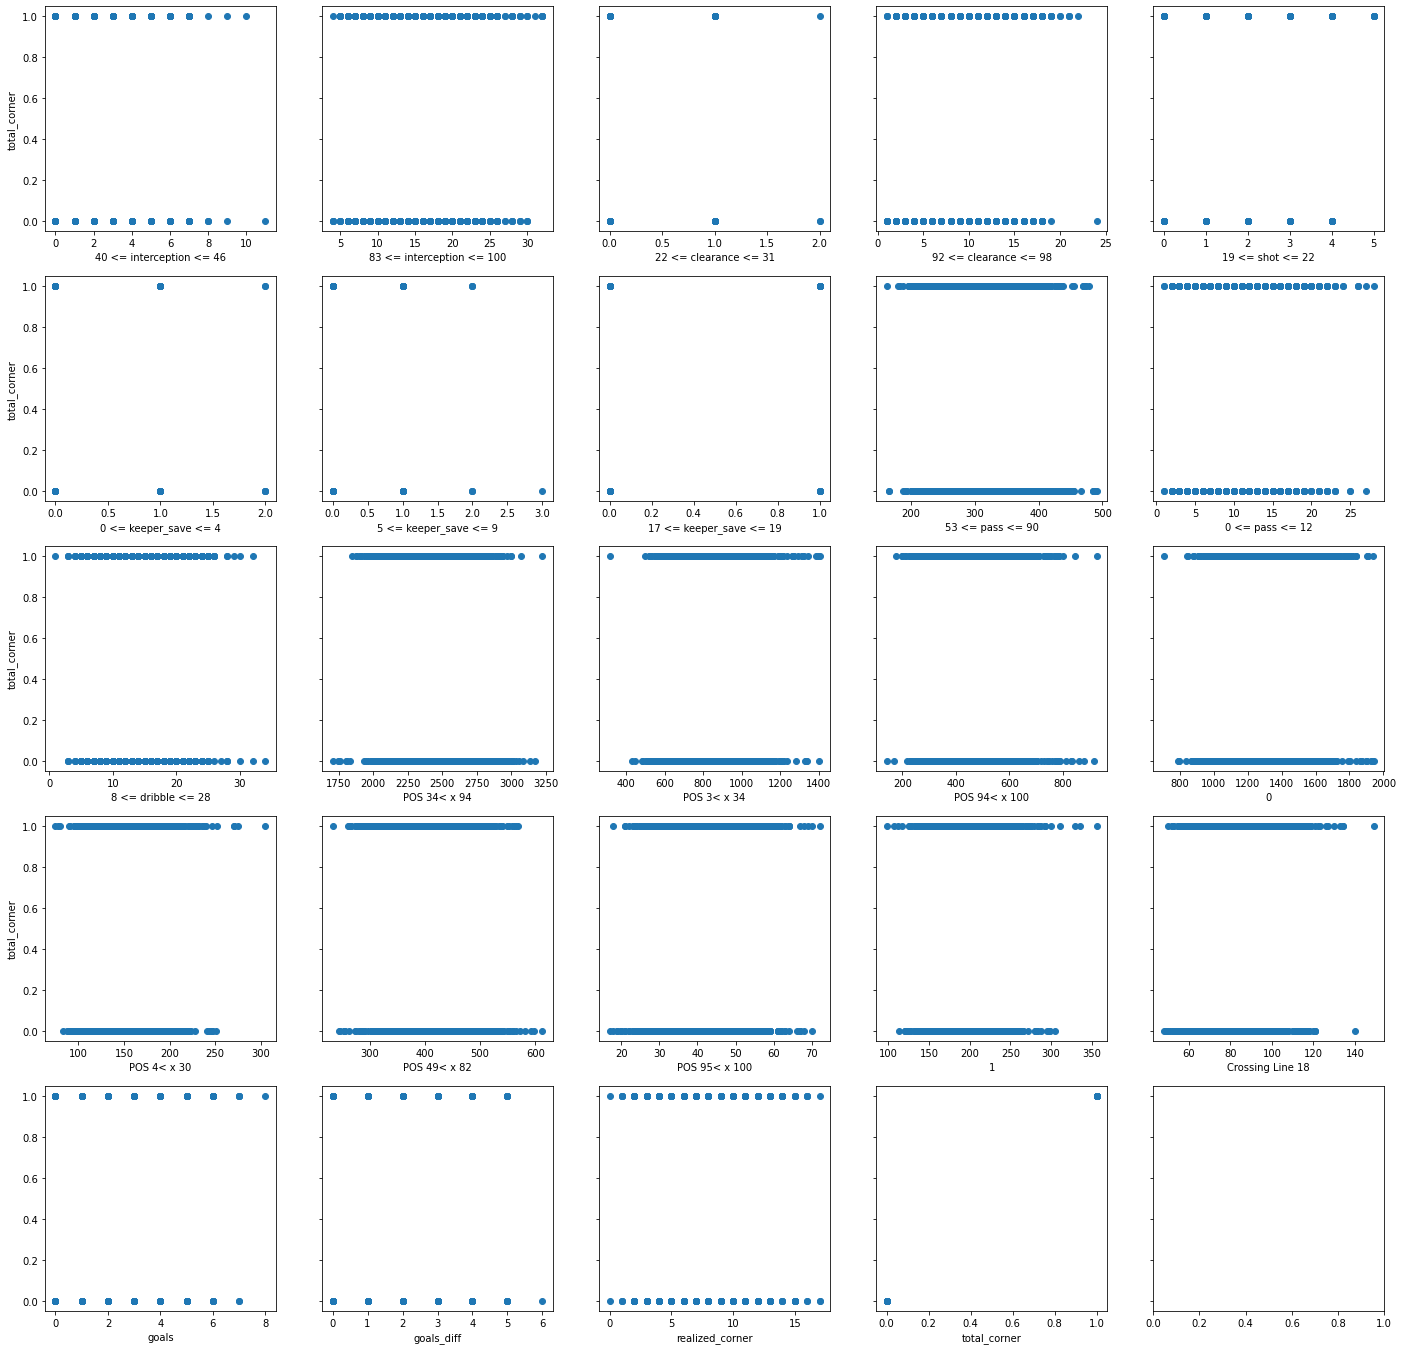

In [ ]:
#@title
fig, ax = plt.subplots(5,5, figsize=(24, 24), sharey=True)
for i in range(0,24):
    ax[i//5, i%5].scatter(x=df_final[df_final.columns[i]], y=df_final["total_corner"])
    ax[i//5, i%5].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")

Text(0, 0.5, 'total_corner')

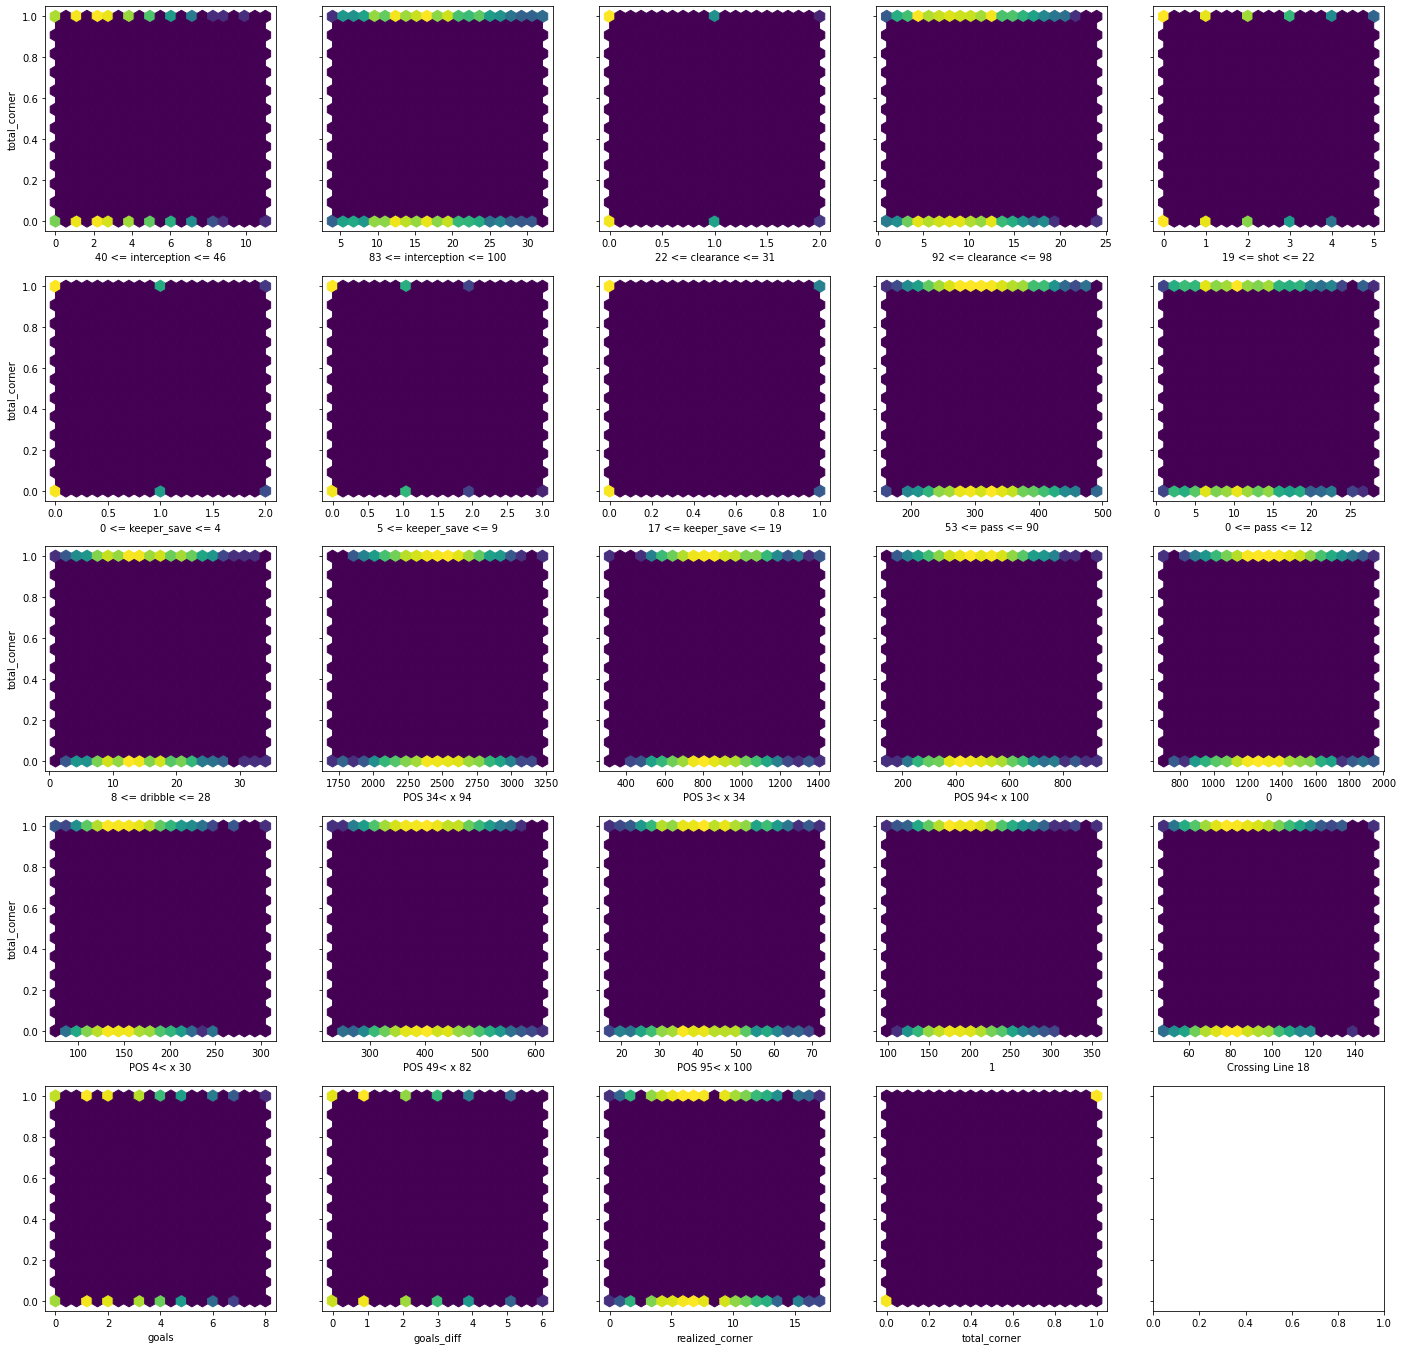

In [ ]:
#@title
fig, ax = plt.subplots(5,5, figsize=(24, 24), sharey=True)
for i in range(0,24):
    ax[i//5, i%5].hexbin(x=df_final[df_final.columns[i]], y=df_final["total_corner"], gridsize=20, bins="log")
    ax[i//5, i%5].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")

Text(0, 0.5, 'total_corner')

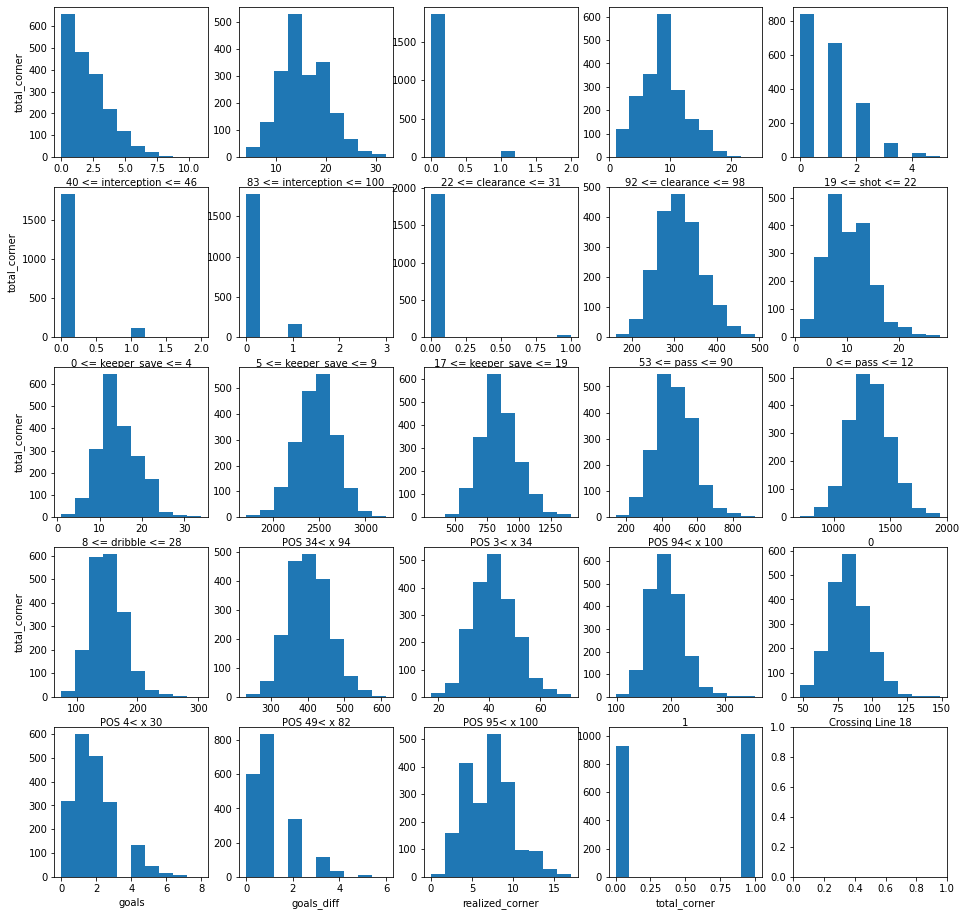

In [ ]:
#@title
fig, ax = plt.subplots(5,5, figsize=(16, 16))
for i in range(0,24):
    ax[i//5, i%5].hist(df_final[df_final.columns[i]])
    ax[i//5, i%5].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")

In [ ]:
#@title
for i, val in enumerate(df_final.columns[:-1]):
  if min(df_final[val]) == 0:
    df_final[val] = df_final[val] + 1

Text(0, 0.5, 'total_corner')

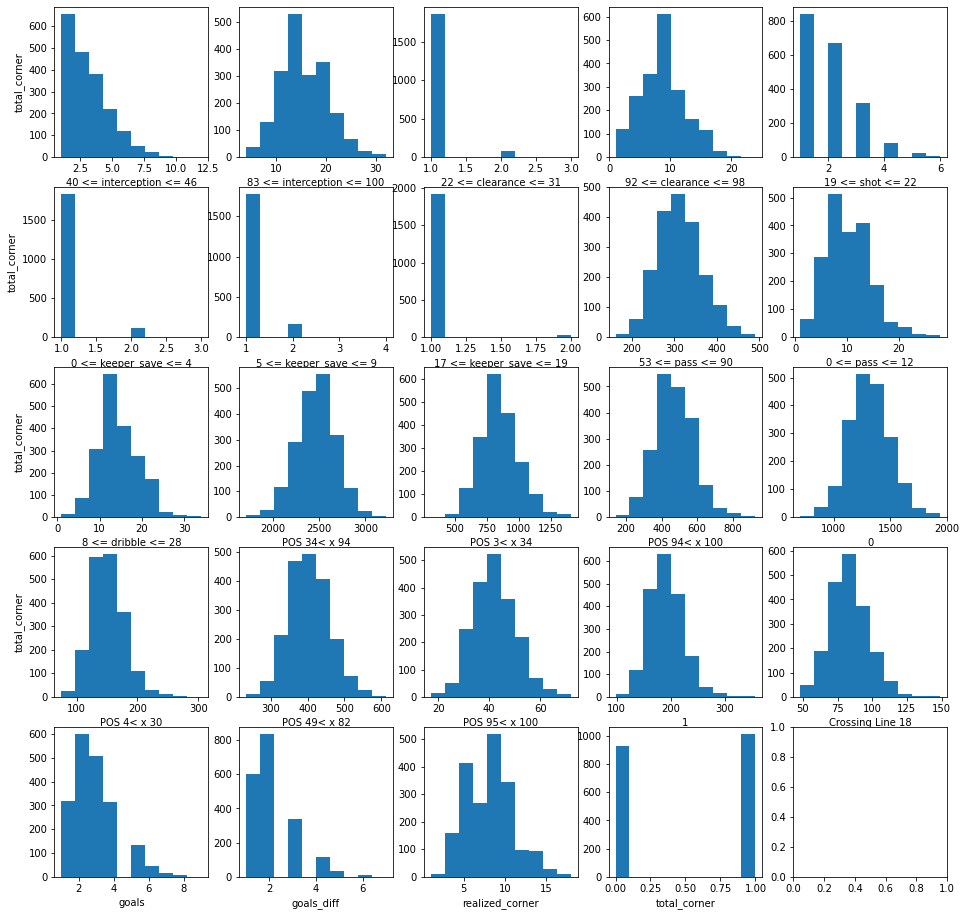

In [ ]:
#@title
fig, ax = plt.subplots(5,5, figsize=(16, 16))
for i in range(0,24):
    ax[i//5, i%5].hist(df_final[df_final.columns[i]])
    ax[i//5, i%5].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")

In [ ]:
#@title
X = df_final[df_final.columns[:-1]]
y = df_final[df_final.columns[-1]]

In [ ]:
#@title
from scipy.stats import boxcox 
lamdas = []
for i, val in enumerate(X.columns):
  X[val], fitted_lambda = boxcox(X[val])
  lamdas.append(fitted_lambda)
  print(fitted_lambda)

0.36619148368923443
0.6365382127069596
-31.55061227586071
0.6226856376446627
-0.4348558240345756
-23.236843895557246
-16.325024537158303
-112.01084283489318
0.4110305721826023
0.565413094327738
0.6613721188831335
1.3804887582375698
0.3922556185592874
0.5949036747017926
0.6082888980726718
-0.04188944695563018
0.4373272408330255
0.6030203326043962
0.04221805630014217
0.21047801565457494
0.2974673608612661
-0.048093449619498845
0.5458196806832086


Text(0, 0.5, 'Count')

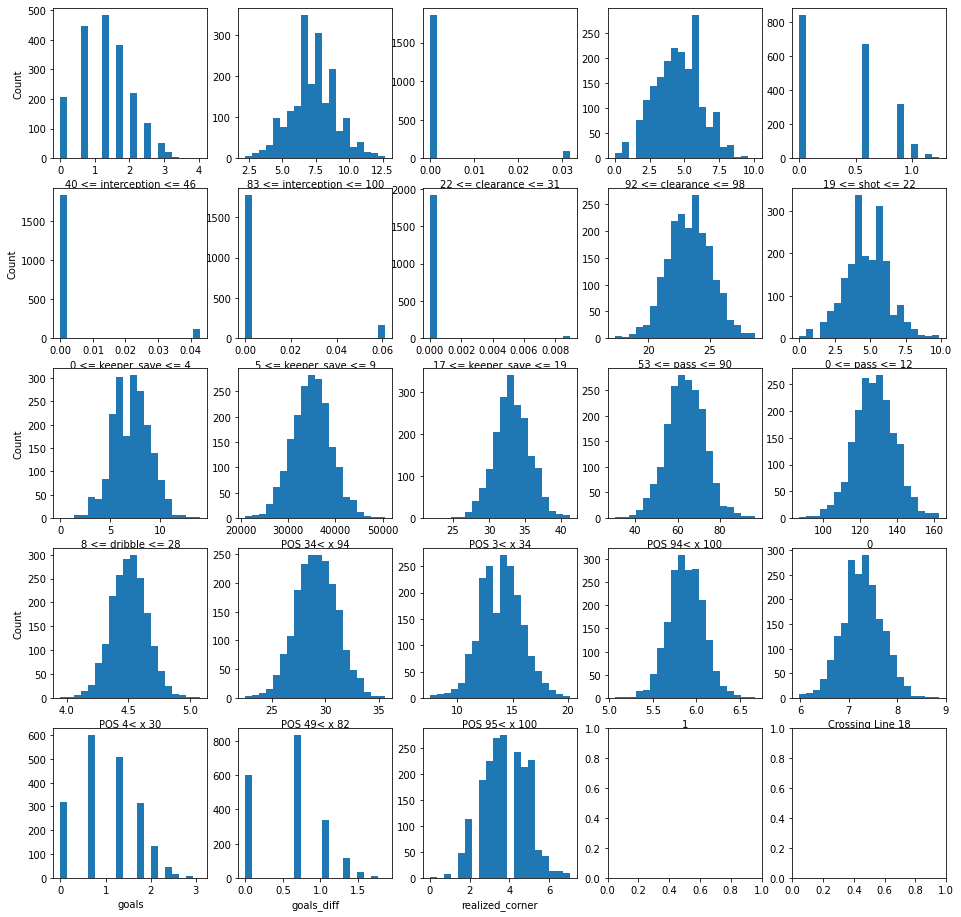

In [ ]:
#@title
fig, ax = plt.subplots(5,5, figsize=(16, 16))
for i in range(0,23):
    ax[i//5, i%5].hist(X[X.columns[i]], bins=20)
    ax[i//5, i%5].set_xlabel(X.columns[i])
ax[0,0].set_ylabel("Count")
ax[1,0].set_ylabel("Count")
ax[2,0].set_ylabel("Count")
ax[3,0].set_ylabel("Count")

In [ ]:
#@title
from scipy.stats import shapiro 
for i, val in enumerate(X.columns):  
  print(shapiro(X[val]))

ShapiroResult(statistic=0.9501555562019348, pvalue=3.6475717848968137e-25)
ShapiroResult(statistic=0.9941986799240112, pvalue=6.776123200324946e-07)
ShapiroResult(statistic=0.20844817161560059, pvalue=0.0)
ShapiroResult(statistic=0.99168860912323, pvalue=4.5945243165590455e-09)
ShapiroResult(statistic=0.7999482154846191, pvalue=8.688050478813866e-44)
ShapiroResult(statistic=0.25225532054901123, pvalue=0.0)
ShapiroResult(statistic=0.31349891424179077, pvalue=0.0)
ShapiroResult(statistic=0.08674108982086182, pvalue=0.0)
ShapiroResult(statistic=0.9993199706077576, pvalue=0.7309368848800659)
ShapiroResult(statistic=0.9932613968849182, pvalue=9.339365902860663e-08)
ShapiroResult(statistic=0.9951163530349731, pvalue=5.565447281696834e-06)
ShapiroResult(statistic=0.9992877244949341, pvalue=0.6906916499137878)
ShapiroResult(statistic=0.9980944395065308, pvalue=0.022611018270254135)
ShapiroResult(statistic=0.9985110759735107, pvalue=0.08446645736694336)
ShapiroResult(statistic=0.998618781566619

In [ ]:
#@title
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler()
scaled_arr = scaled.fit_transform(X)

In [ ]:
#@title
!pip install lazypredict
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
y.value_counts()

1.00    1012
0.00     929
Name: total_corner, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_cls, predictions_cls = clf.fit(X_train, X_test, y_train, y_test)
models_cls

100%|██████████| 29/29 [00:05<00:00,  5.13it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.57,0.57,0.57,0.57,0.02
GaussianNB,0.57,0.57,0.57,0.57,0.02
SVC,0.57,0.57,0.57,0.57,0.28
ExtraTreesClassifier,0.57,0.57,0.57,0.57,0.33
BernoulliNB,0.56,0.56,0.56,0.56,0.02
LinearDiscriminantAnalysis,0.56,0.56,0.56,0.56,0.10
LogisticRegression,0.56,0.56,0.56,0.56,0.06
CalibratedClassifierCV,0.56,0.55,0.55,0.55,0.98
RidgeClassifierCV,0.55,0.55,0.55,0.55,0.03


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

In [ ]:
knn_2 = KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn_2, n_features_to_select=None, direction="backward",
                                scoring="accuracy", cv=5, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)
sfs.fit_transform(X_train,y_train)
print(X_train.columns)

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10, scoring='accuracy')
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

results_clf = pd.DataFrame(clf.cv_results_['params'])
results_clf['test_score'] = clf.cv_results_['mean_test_score']
# predict the target on the test dataset
clf_ypred = clf.predict(X_test)
# Accuracy Score on test dataset
clf_accuracy_test = accuracy_score(y_test,clf_ypred)
print('accuracy_score on test dataset : ', clf_accuracy_test)

clf_cm = confusion_matrix(y_test, clf_ypred)
print(clf_cm)
print(clf.best_params_)
clf_cr = classification_report(y_test, clf_ypred)
print(clf_cr)

knn_best = clf.best_estimator_

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner'],
      dtype='object')
Best leaf_size: 1
Best p: 2
Best n_neighbors: 1
accuracy_score on test dataset :  0.5248713550600344
[[141 139]
 [138 165]]
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
              precision    recall  f1-score   support

    

In [ ]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb, n_features_to_select=None, direction="backward",
                                scoring="accuracy", cv=5, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)
sfs.fit_transform(X_train,y_train)
print(X_train.columns)
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=19)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=gnb, param_grid=params_NB, cv=cv_method,verbose=1,scoring='accuracy')
gs_NB.fit(X_train, y_train)
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
# predict the target on the test dataset
gnb_ypred = gs_NB.predict(X_test)
# Accuracy Score on test dataset
gnb_accuracy_test = accuracy_score(y_test,gnb_ypred)
print('accuracy_score on test dataset : ', gnb_accuracy_test)

gnb_cm = confusion_matrix(y_test, gnb_ypred)
print(gnb_cm)
print(gs_NB.best_params_)
gnb_cr = classification_report(y_test, gnb_ypred)
print(gnb_cr)

gnb_best = gs_NB.best_estimator_

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner'],
      dtype='object')
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
accuracy_score on test dataset :  0.5523156089193825
[[143 137]
 [124 179]]
{'var_smoothing': 1.2328467394420635e-09}
              precision    recall  f1-score

In [ ]:
from sklearn.svm import SVC
SVC = SVC(probability=True)

sfs = SequentialFeatureSelector(SVC, n_features_to_select=None, direction="backward",
                                scoring="accuracy", cv=5, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)
sfs.fit_transform(X_train,y_train)
print(X_train.columns)
param_grid1 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
svc_grid = GridSearchCV(SVC, param_grid1, refit = True, verbose = 0)
# fitting the model for grid search
svc_grid.fit(X_train, y_train)
# print best parameter after tuning
print(svc_grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(svc_grid.best_estimator_)

svc_ypred = svc_grid.predict(X_test)
svc_accuracy_test = accuracy_score(y_test,svc_ypred)
print('accuracy_score on test dataset : ', svc_accuracy_test)
svc_cm = confusion_matrix(y_test, svc_ypred)
print(svc_cm)
svc_cr = classification_report(y_test, svc_ypred)
print(svc_cr)

svc_best = svc_grid.best_estimator_

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner'],
      dtype='object')
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1, probability=True)
accuracy_score on test dataset :  0.5214408233276158
[[  2 278]
 [  1 302]]
              precision    recall  f1-score   support

         0.0   

In [ ]:
svc_best = svc_grid.best_estimator_

In [ ]:
tree = ExtraTreesClassifier()
sfs = SequentialFeatureSelector(tree, n_features_to_select=None, direction="backward",
                                scoring="accuracy", cv=5, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)
sfs.fit_transform(X_train,y_train)
print(X_train.columns)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ["auto", "log2"]
criterion = ["gini", "entropy"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               "max_features" : max_features,
               "criterion" : criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tree_random = RandomizedSearchCV(estimator = tree, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, scoring='accuracy', random_state=42, n_jobs = -1)# Fit the random search model
tree_random.fit(X_train, y_train)

# predict the target on the test dataset
tree_ypred = tree_random.predict(X_test)
# Accuracy Score on test dataset
etc_accuracy_test = accuracy_score(y_test,tree_ypred)
print('accuracy_score on test dataset : ', etc_accuracy_test)

tree_cm = confusion_matrix(y_test, tree_ypred)
print(tree_cm)
print(tree_random.best_params_)
tree_cr = classification_report(y_test, tree_ypred)
print(tree_cr)

tree_best = tree_random.best_estimator_

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner'],
      dtype='object')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
accuracy_score on test dataset :  0.5694682675814752
[[129 151]
 [100 203]]
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 

In [ ]:
lr = LogisticRegression()

sfs = SequentialFeatureSelector(lr, n_features_to_select=None, direction="backward",
                                scoring="accuracy", cv=5, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=.3)
sfs.fit_transform(X_train,y_train)
print(X_train.columns)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2',"elasticnet"]
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_gc = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
lr_result = lr_gc.fit(X_train, y_train)

lr_ypred = lr_result.predict(X_test)
# Accuracy Score on test dataset
lr_accuracy_test = accuracy_score(y_test,lr_ypred)
print('accuracy_score on test dataset : ', lr_accuracy_test)

lr_cm = confusion_matrix(y_test, lr_ypred)
print(lr_cm)
print(lr_result.best_params_)
lr_cr = classification_report(y_test, lr_ypred)
print(lr_cr)

lr_best = lr_result.best_estimator_

Index([ '40 <= interception <= 46', '83 <= interception <= 100',
           '22 <= clearance <= 31',     '92 <= clearance <= 98',
                '19 <= shot <= 22',     '0 <= keeper_save <= 4',
           '5 <= keeper_save <= 9',   '17 <= keeper_save <= 19',
                '53 <= pass <= 90',           '0 <= pass <= 12',
              '8 <= dribble <= 28',              'POS 34< x 94',
                     'POS 3< x 34',             'POS 94< x 100',
                                 0,               'POS 4< x 30',
                    'POS 49< x 82',             'POS 95< x 100',
                                 1,          'Crossing Line 18',
                           'goals',                'goals_diff',
                 'realized_corner'],
      dtype='object')
accuracy_score on test dataset :  0.5574614065180102
[[136 144]
 [114 189]]
{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

         0.0       0.54      0.49      0.51 

In [ ]:
from sklearn.ensemble import VotingClassifier
model1 = knn_best
model2 = gnb_best
model3 = tree_best
model4 = lr_best
model5= svc_best
model = VotingClassifier(estimators=[('KNN', model1), ('GNB', model2), ("ETC", model3), ("LR", model4), ("SVC", model5)], voting='soft')
model.fit(X_train,y_train)

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(leaf_size=1, n_neighbors=1)),
                             ('GNB',
                              GaussianNB(var_smoothing=1.2328467394420635e-09)),
                             ('ETC',
                              ExtraTreesClassifier(bootstrap=True,
                                                   criterion='entropy',
                                                   max_depth=110,
                                                   min_samples_split=10,
                                                   n_estimators=1000)),
                             ('LR',
                              LogisticRegression(C=100, solver='newton-cg')),
                             ('SVC', SVC(C=10, gamma=0.1, probability=True))],
                 voting='soft')

In [ ]:
pred_ens = model.predict(X_test) 

vc_accuracy_test = accuracy_score(y_test,pred_ens)
print('accuracy_score on test dataset : ', vc_accuracy_test)
print(classification_report(y_test, pred_ens)) 
cm = confusion_matrix(y_test, pred_ens)
print(cm)

accuracy_score on test dataset :  0.548885077186964
              precision    recall  f1-score   support

         0.0       0.53      0.48      0.50       280
         1.0       0.56      0.61      0.59       303

    accuracy                           0.55       583
   macro avg       0.55      0.55      0.55       583
weighted avg       0.55      0.55      0.55       583

[[134 146]
 [117 186]]


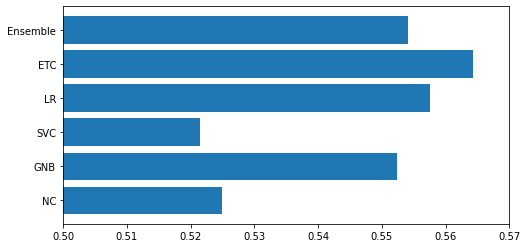

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.barh(['NC', 'GNB','SVC', 'LR',"ETC", "Ensemble"], [clf_accuracy_test, gnb_accuracy_test, svc_accuracy_test, lr_accuracy_test, etc_accuracy_test,  vc_accuracy_test])
plt.xlim(0.50, 0.57)
plt.show()



In [ ]:
len(X_test)

583

In [ ]:
from sklearn.metrics import recall_score
def best_recall_finder(model):
  y_scores = model.predict_proba(X_test)
  p_proba = pd.DataFrame(y_scores, columns=["prob_0","prob_1"])
  y_actual = pd.DataFrame(y_test.values, columns=["y_actual"])
  y_pred = pd.DataFrame(tree_ypred, columns=["y_pred"])
  df = pd.concat([p_proba, y_actual, y_pred], axis=1)

  best_i = 50
  best_score = 0
  for i in range(50, 70):
    final_pred = df[df["prob_0"]>i/100]
    y_true = final_pred["y_actual"]
    y_pred = final_pred["y_pred"]
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=0)
    if best_score < recall:
      best_score = recall 
      best_i = i
  print(df[df["prob_0"]>best_i/100])
  print("For 0's")
  print("Best Recall is: " + str(best_score))
  print("Best prob value is: " + str(best_i))
  print(cm)
  print(cr)

  best_j = 50
  best_score = 0
  for j in range(50, 70):
    final_pred = df[df["prob_1"]>j/100]
    y_true = final_pred["y_actual"]
    y_pred = final_pred["y_pred"]
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=1)
    if best_score < recall:
      best_score = recall 
      best_j = j
  print(print(df[df["prob_1"]>best_j/100]))
  print("For 1's")
  print("Best Recall is: " + str(best_score))
  print("Best prob value is: " + str(best_j))
  print(cm)
  print(cr)

  df_concat = pd.concat([df[df["prob_0"]>best_i/100], df[df["prob_1"]>best_j/100]], axis=0)
  y_true = df_concat["y_actual"]
  y_pred = df_concat["y_pred"]
  cm = confusion_matrix(y_true, y_pred)
  cr = classification_report(y_true, y_pred)
  print(cm)
  print(cr)

In [ ]:
best_recall_finder(model)

     prob_0  prob_1  y_actual  y_pred
8      0.74    0.26      1.00    0.00
21     0.69    0.31      0.00    0.00
70     0.73    0.27      0.00    0.00
87     0.71    0.29      0.00    0.00
122    0.75    0.25      0.00    0.00
130    0.71    0.29      0.00    0.00
215    0.75    0.25      1.00    0.00
220    0.70    0.30      0.00    0.00
223    0.70    0.30      0.00    0.00
242    0.78    0.22      1.00    0.00
270    0.74    0.26      0.00    0.00
272    0.70    0.30      1.00    0.00
281    0.70    0.30      1.00    0.00
308    0.78    0.22      1.00    0.00
326    0.71    0.29      1.00    0.00
333    0.72    0.28      1.00    0.00
349    0.73    0.27      1.00    0.00
380    0.72    0.28      1.00    0.00
382    0.74    0.26      1.00    0.00
433    0.70    0.30      1.00    0.00
446    0.72    0.28      0.00    0.00
456    0.71    0.29      0.00    0.00
480    0.71    0.29      0.00    0.00
493    0.73    0.27      0.00    0.00
524    0.74    0.26      0.00    0.00
528    0.70 